# Imports and materials

In [1]:
%load_ext autoreload
%autoreload 2
import gdsfactory as gf
import numpy as np
import pmag as pm
import os
from datetime import datetime
import dill
import tidy3d as td
import matplotlib.pyplot as plt
import gplugins.tidy3d as gt
import gplugins as gp
import gplugins.sax as gsax
import sax
if 'mats' in dir():
    print("mats already defined")
else:
    # mats = pm.materials.init_materials(['nitride', 'oxide', 'diamond'], plot=False)
    mats = pm.materials.init_materials(['nitride', 'oxide', 'diamond'], plot=False)

layer_kwargs = {
    "box_thickness": 1, 
    "upper_nitride_thickness": .2, 
    "upper_nitride_bottom_depth": 2, 
    "lower_nitride_thickness": .1, 
    "lower_nitride_top_depth": 2.12, 
    "diamond_thickness": .2,
}
pdk = pm.pdks.get_nitride_window_pdk()
pdk.activate()
layer_stack = pm.layers.get_nitride_window_layer_stack(**layer_kwargs)

Initializing nitride material
Initializing oxide material
Initializing diamond material


# Pipeline Tools

In [2]:

def get_date_time_file_path(parent_folder, filename="_sim_data.hdf5"):
    """Generic date folder creation and time file name creation for saving files."""
    date_folder = datetime.today().strftime('/%Y-%m-%d')
    if not os.path.exists(parent_folder + date_folder):
        os.makedirs(parent_folder + date_folder)
    time_formatted = datetime.today().strftime('/%Hh-%Mm-%Ss')
    return parent_folder + date_folder + time_formatted + filename
def get_sp_output(sp, inputs, outputs):
    '''Returns the output of a given set of inputs for each output port
    inputs:
        sp: sparamters dictionary
        inputs: dict{port: {modes: [mode_nums], amps: [amps], phases: [phases]}}
        outputs: dict{port: {modes: [mode_nums]}}
    '''
    s_out = {}
    for output_port, output_port_dict in outputs.items():
        for output_mode in output_port_dict['modes']:
            s = 0j
            input_mode_str = ''
            for input_port, port_dict in inputs.items():
                input_mode_str += f'+{input_port}@{[f'a{mode_num}' for mode_num in port_dict["modes"]]}'
                for input_mode, input_amp, input_phase in zip(port_dict['modes'], port_dict['amps'], port_dict['phases']):
                    # print(f"Adding {input_port}@{input_mode},{output_port}@{output_mode} with amp {input_amp} and phase {input_phase}")
                    s += input_amp * np.exp(1j * input_phase) * sp[f'{input_port}@{input_mode},{output_port}@{output_mode}']
            input_mode_str = input_mode_str[1:]
            s_string = f'{input_mode_str},{output_port}@{output_mode}'
            s_out[s_string] = s
    return s_out

# modeler.simulation.plot(z=td_c.get_layer_center("upper_nitride")[2])
# input_ports = ['o1', 'o1']
# input_phase= {
#     'o1': 0,
#     'o1': np.pi,
# }
# output_ports = ['o1', 'o2', 'o3', 'o4']

# sources = []
# monitors = []
# monitors.append(td.FieldMonitor(name='field', center=[0,0, td_c.get_layer_center("upper_nitride")[2]], size=[td.inf, td.inf, 0], interval_space=(4,4,1), freqs=[td.C_0/0.619]))
# for port_source in modeler.ports:
#     if port_source.name in input_ports:
#         mode_source_0 = modeler.to_source(port=port_source, mode_index=0, phase=input_phase[port_source.name])
#         sources.append(mode_source_0)
#     if port_source.name in output_ports:
#         mode_monitor_0 = modeler.to_monitor(port=port_source)
#         monitors.append(mode_monitor_0)
# sim = modeler.simulation.copy(update=dict(sources=sources, monitors=monitors))
# sim.plot(x=None, y=0, z=None)

# pm.tidytools.validate_sim_for_daily_allowance(sim)

# job = td.web.Job(simulation=sim, task_name=f"multiport")
# data = job.run()

# Journey

## Journey Init

In [11]:
journey = {
    'variables': {
        'ring_params': dict(ring_gap=0.2, double_gap=0.2, length_x=10, width=0.4, length_extension=3, radius=5, bend_dx=8, bend_dy=3, bend_padding=4, layer='UPPER_NITRIDE', crop_bottom_x=0)
    },
    'settings': {
        'half_component_args': {
            'layer_stack': layer_stack,
            'material_mapping': mats, 
            'pad_xy_inner': 0,
            'pad_xy_outer': 0,
            'pad_z_inner': 0,
            'pad_z_outer': 0,
            'extend_ports': 0,
            'port_offset': 0,
        },
        'half_modeler_args': {
            'center_z': "upper_nitride",
            'port_size_mult': (5, 4),
            'sim_size_z': 1.5,
            'crop_x': 2,
            'crop_y': 0,
            'shift_x': 0,
            'shift_y': -1.5,
            'wavelength': 0.619,
            'bandwidth': 0.01,
            'num_freqs': 101,
            'symmetry': (0,0,1),
            'min_steps_per_wvl': 16,
            'run_time': 1.4e-12,
            'mode_spec': td.ModeSpec(num_modes=1, filter_pol="te"),
            'boundary_spec': td.BoundarySpec(
            x=td.Boundary(minus=td.PML(), plus=td.PML()),
            y=td.Boundary(minus=td.PML(), plus=td.PML()),
            z=td.Boundary(minus=td.PML(), plus=td.PML()),
            )
        },
        'half_resonance_args': {
            'L': 35,
            'neff': 1.8,
            'alpha': 0.8,
            'phase_offset': 0*np.pi,
        },
        'full_component_args': {
            'layer_stack': layer_stack,
            'material_mapping': mats,
            'pad_xy_inner': 0,
            'pad_xy_outer': 0,
            'pad_z_inner': 0,
            'pad_z_outer': 0,
            'extend_ports': 0,
            'port_offset': 0,
        },
        'full_modeler_args': {
            'center_z': "upper_nitride",
            'port_size_mult': (5, 4),
            'sim_size_z': 1.5,
            'crop_x': 5,
            'crop_y': -2,
            'shift_x': 0,
            'shift_y': 0,
            'wavelength': 0.619,
            'bandwidth': 0.01,
            'num_freqs': 101,
            'symmetry': (0,0,1),
            'min_steps_per_wvl': 15,
            'run_time': 1.8e-12,
            'mode_spec': td.ModeSpec(num_modes=1, filter_pol='te'),
            'boundary_spec': td.BoundarySpec(
            x=td.Boundary(minus=td.PML(), plus=td.PML()),
            y=td.Boundary(minus=td.PML(), plus=td.PML()),
            z=td.Boundary(minus=td.PML(), plus=td.PML()),),
        }
    }
}


## Half size S-Parameters

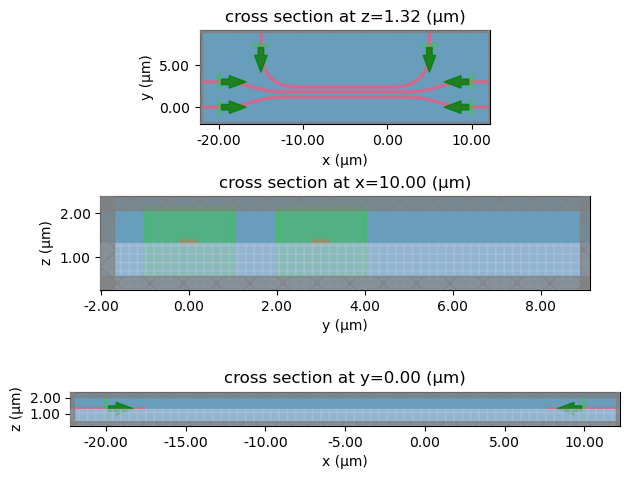

Grid size (46191600) and total time steps (40617) are within daily allowance.


In [5]:
# setup the tidy3d component
c = pm.devices.extended_double_coupler_ring(**journey['variables']['ring_params'])
td_c = gt.Tidy3DComponent(component=c,**journey['settings']['half_component_args'])
# initialize the tidy3d ComponentModeler
modeler = td_c.get_component_modeler(**journey['settings']['half_modeler_args'])

# we can plot the tidy3d simulation setup
fig, ax = plt.subplots(3, 1)
modeler.plot_sim(z=td_c.get_layer_center("upper_nitride")[2], ax=ax[0])
modeler.plot_sim(x=td_c.ports[0].dcenter[0], ax=ax[1])
modeler.plot_sim(y=td_c.ports[0].dcenter[1], ax=ax[2])
fig.tight_layout()
plt.show()

pm.tidytools.validate_sim_for_daily_allowance(modeler.simulation)

14:16:58 EDT WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.web.run(...)' or the deprecated    
             'tidy3d.plugins.mode.web.run(...)'.                                

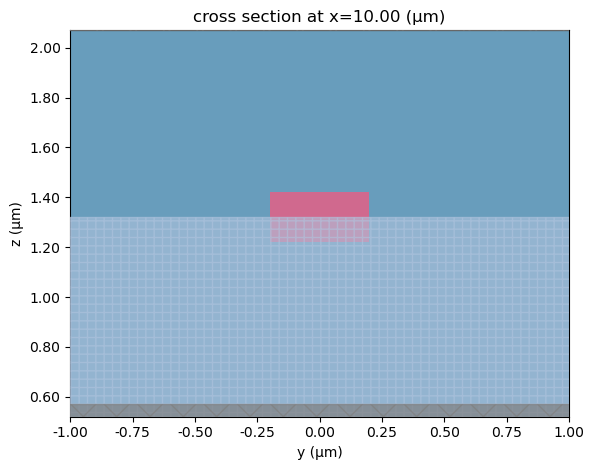

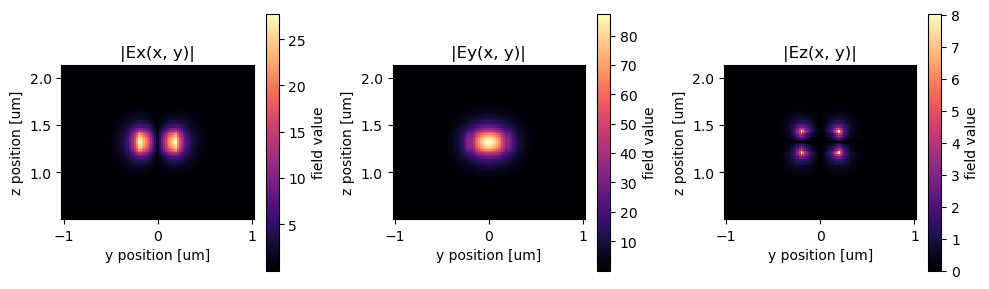

In [6]:

sp = gt.write_sparameters(
    component=c,
    **journey['settings']['half_component_args'],
    **journey['settings']['half_modeler_args'],
    plot_mode_index=0,
    web_modes=False,
    plot_mode_port_name=c.ports[0].name,
)

In [7]:
sp = gt.write_sparameters(
    component=c,
    **journey['settings']['half_component_args'],
    **journey['settings']['half_modeler_args'],
    run_only=[('o1', 0), ('o2', 0), ('o3', 0)], # run only the (port, mode_index)
)

Output()

14:18:13 EDT Started working on Batch containing 3 tasks.

14:18:15 EDT Maximum FlexCredit cost: 4.210 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:34:09 EDT Batch complete.

Output()

Simulation saved to PosixPath('/home/floresh2/.gdsfactory/sparameters/13f3a5decc43a2b526f440ccfe970a6ac8b416532da47d1f0546a5bec1bb882f.npz')


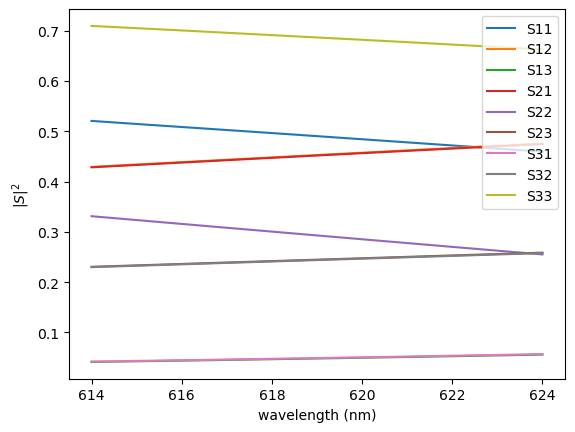

In [9]:

sm = {
    'S11': sp['o1@0,o6@0'], 'S12': sp['o2@0,o6@0'], 'S13': sp['o3@0,o6@0'],
    'S21': sp['o1@0,o5@0'], 'S22': sp['o2@0,o5@0'], 'S23': sp['o3@0,o5@0'],
    'S31': sp['o1@0,o4@0'], 'S32': sp['o2@0,o4@0'], 'S33': sp['o3@0,o4@0'],
    'wavelengths': sp['wavelengths']
}
gp.plot.plot_sparameters(sm, logscale=False, with_simpler_labels=False)
# gp.plot.plot_sparameters(sp, plot_phase=True, with_simpler_labels=False)

# S = np.array([[sm['S11'], sm['S12'], sm['S13']], [sm['S21'], sm['S22'], sm['S23']], [sm['S31'], sm['S32'], sm['S33']]])
# print(np.sum(np.abs(S[:,:,0])**2, axis=0))
# print(np.sum(np.abs(S[:,:,0])**2, axis=1))
# print(S[:,:,0])

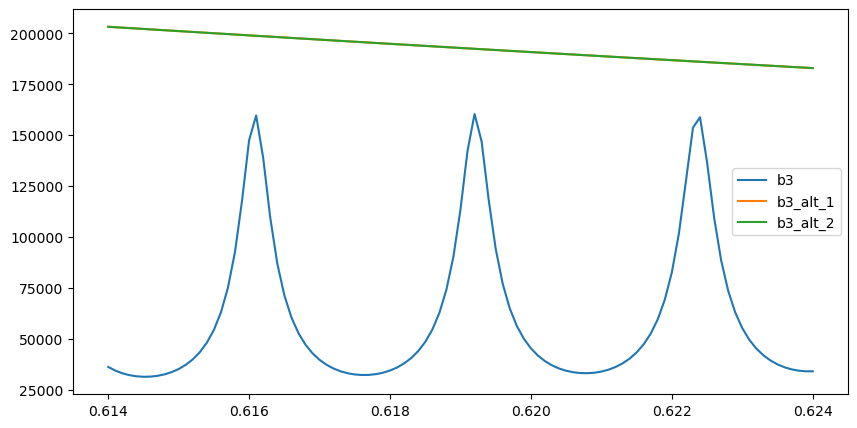

In [34]:
# Calculate the critical coupling
rt_phase = 2*np.pi*journey['settings']['half_resonance_args']['L']*journey['settings']['half_resonance_args']['neff']/sm['wavelengths']+journey['settings']['half_resonance_args']['phase_offset']
S11, S12, S13, S21, S22, S23, S31, S32, S33 = sm['S11'], sm['S12'], sm['S13'], sm['S21'], sm['S22'], sm['S23'], sm['S31'], sm['S32'], sm['S33']
a1_ratio = (S22/S23-S12/S13)/(S11/S13-S21/S23)

a1 = 1
a2 = a1/a1_ratio
norm_factor = np.sqrt(np.abs(a1)**2+np.abs(a2)**2)/100000
a1 = a1/norm_factor
a2 = a2/norm_factor

b3 = (S31*a1+S32*a2)/(1-S33*journey['settings']['half_resonance_args']['alpha']*np.exp(1j*rt_phase))
a3= b3*journey['settings']['half_resonance_args']['alpha']*np.exp(1j*rt_phase)

b1 = S11*a1 + S12*a2 + S13*a3
b2 = S21*a1 + S22*a2 + S23*a3

# print(f"a1: {a1}, a2: {a2}, a3: {a3}, b1: {b1}, b2: {b2}, b3: {b3}")
plt.figure(figsize=(10, 5))
# plt.plot(sm['wavelengths'], np.abs(b1), label='b1')
# plt.plot(sm['wavelengths'], np.abs(b2), label='b2')
plt.plot(sm['wavelengths'], np.abs(b3), label='b3')
plt.plot(sm['wavelengths'], np.abs((S11*a1+S12*a2)/S13/journey['settings']['half_resonance_args']['alpha']), label='b3_alt_1')
plt.plot(sm['wavelengths'], np.abs((S21*a1+S22*a2)/S23/journey['settings']['half_resonance_args']['alpha']), label='b3_alt_2')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(sm['wavelengths'], np.abs(a1), label='a1')
# plt.plot(sm['wavelengths'], np.abs(a2), label='a2')
# plt.plot(sm['wavelengths'], np.abs(a3), label='a3')
# plt.legend()
# plt.show()

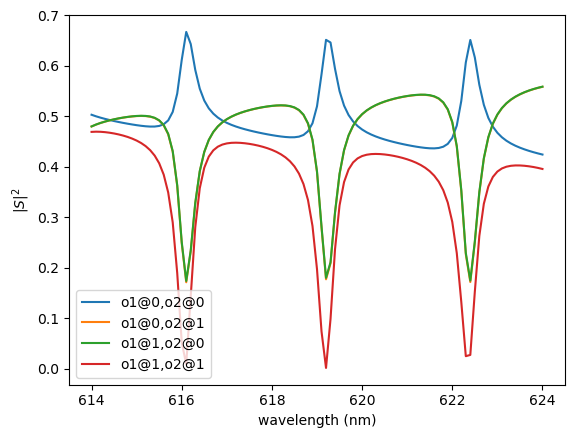

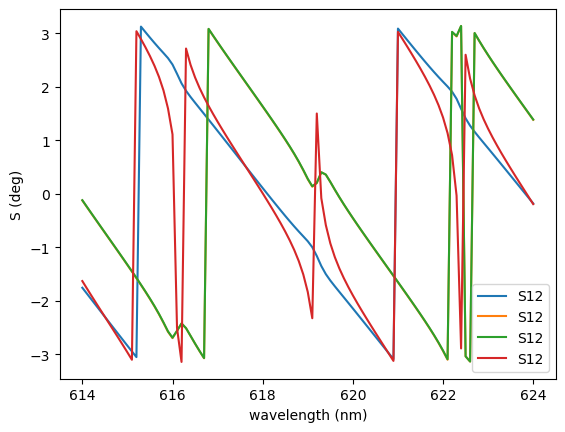

In [35]:
rt_phase = 2*np.pi*journey['settings']['half_resonance_args']['L']*journey['settings']['half_resonance_args']['neff']/sm['wavelengths']+journey['settings']['half_resonance_args']['phase_offset']

########################## Plot a1 input s-parameters
a1 = 1
a2 = 0
b3 = (sm['S31']*a1+sm['S32']*a2)/(1-sm['S33']*journey['settings']['half_resonance_args']['alpha']*np.exp(1j*rt_phase))
# Loopback condition
a3 = b3*journey['settings']['half_resonance_args']['alpha']*np.exp(1j*rt_phase)

a1_b2 = sm['S21']*a1+sm['S22']*a2+sm['S23']*a3
a1_b1 = sm['S11']*a1+sm['S12']*a2+sm['S13']*a3

########################## Plot a2 input s-parameters
a1 = 0
a2 = 1
b3 = (sm['S31']*a1+sm['S32']*a2)/(1-sm['S33']*journey['settings']['half_resonance_args']['alpha']*np.exp(1j*rt_phase))
# Loopback condition
a3 = b3*journey['settings']['half_resonance_args']['alpha']*np.exp(1j*rt_phase)

a2_b2 = sm['S21']*a1+sm['S22']*a2+sm['S23']*a3
a2_b1 = sm['S11']*a1+sm['S12']*a2+sm['S13']*a3

even_odd_sm = {
    'o1@0,o2@0': a1_b1,
    'o1@0,o2@1': a1_b2,
    'o1@1,o2@0': a2_b1,
    'o1@1,o2@1': a2_b2,
    'wavelengths': sm['wavelengths']
}
gp.plot.plot_sparameters(even_odd_sm, logscale=False, with_simpler_labels=False)
gp.plot.plot_sparameters(even_odd_sm, logscale=False, plot_phase=True)

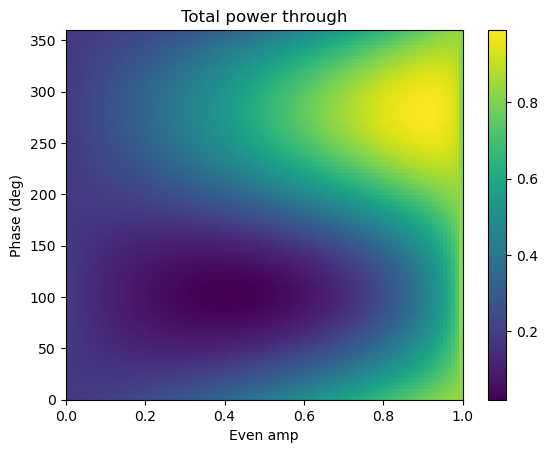

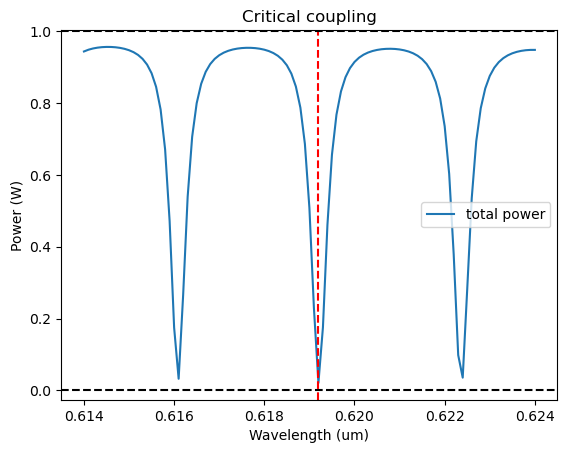

Minimum through power (0.021 W) at even amp 0.410000 and phase 100.80 deg
Minimum through power (0.021 W) at wavelength 0.619 um
Maximum through power (0.990 W) at even amp 0.920000 and phase 280.80 deg


In [36]:
res = 101
phases = np.linspace(0, 360, res)
even_amps = np.linspace(0, 1, res)
odd_amps = np.sqrt(1-even_amps**2)

outputs = {
    'o2': {
        'modes': [0, 1]
    }
}
# plt.figure()
min_total_powers = np.ones((res, res))
for amp_idx, (even_amp, odd_amp) in enumerate(zip(even_amps, odd_amps)):
    for phase_idx, input_phase in enumerate(phases):
        inputs ={
            'o1': {
            'modes': [0, 1],
            'amps': [even_amp, odd_amp],
            'phases': [0, input_phase*np.pi/180]
        }
        }
        s = get_sp_output(even_odd_sm, inputs, outputs)

        total_power = np.zeros(len(even_odd_sm['wavelengths']))
        for s_name, s_value in s.items():
            total_power += np.abs(s_value)**2
        min_power = np.min(total_power)
        min_total_powers[phase_idx, amp_idx] = min_power

min_total_powers = np.array(min_total_powers)
plt.figure()
extent = [even_amps[0], even_amps[-1], phases[0], phases[-1]]
plt.imshow(min_total_powers, aspect='auto', origin='lower', extent=extent)
plt.xlabel('Even amp')
plt.ylabel('Phase (deg)')
plt.title('Total power through')
plt.colorbar()
plt.show()

min_thru = np.unravel_index(np.argmin(min_total_powers), min_total_powers.shape)
max_thru = np.unravel_index(np.argmax(min_total_powers), min_total_powers.shape)
inputs_critical = {
    'o1': {
        'modes': [0, 1],
        'amps': [even_amps[min_thru[1]], odd_amps[min_thru[1]]],
        'phases': [0, phases[min_thru[0]]*np.pi/180]
    }
}
s_critical = get_sp_output(even_odd_sm, inputs_critical, outputs)
total_power = np.zeros(len(even_odd_sm['wavelengths']))
for s_name, s_value in s_critical.items():
    total_power += np.abs(s_value)**2

plt.figure()
plt.plot(even_odd_sm['wavelengths'], total_power, label='total power')
plt.xlabel('Wavelength (um)')
plt.ylabel('Power (W)')
plt.title('Critical coupling')
min_power = np.min(total_power)
min_wavelength = even_odd_sm['wavelengths'][np.argmin(total_power)]
plt.axvline(min_wavelength, color='r', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.axhline(1, color='k', linestyle='--')
plt.legend()
plt.show()
print(f'Minimum through power ({min_total_powers[min_thru[0], min_thru[1]]:.3f} W) at even amp {even_amps[min_thru[1]]:.6f} and phase {phases[min_thru[0]]:.2f} deg')
print(f'Minimum through power ({min_power:.3f} W) at wavelength {min_wavelength:.3f} um')
print(f'Maximum through power ({min_total_powers[max_thru[0], max_thru[1]]:.3f} W) at even amp {even_amps[max_thru[1]]:.6f} and phase {phases[max_thru[0]]:.2f} deg')

## Full size S-Parameters

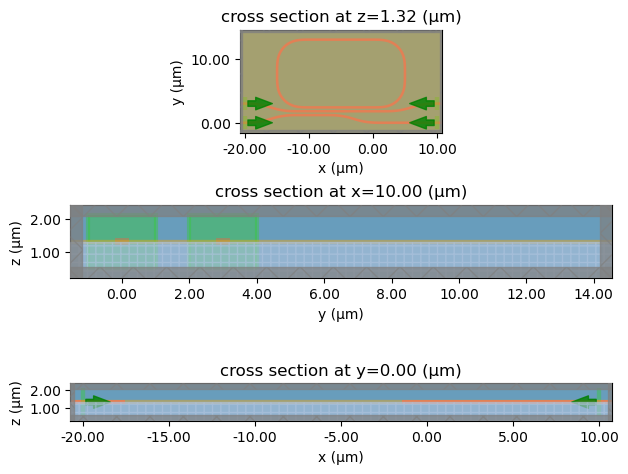

Grid size (51047880) and total time steps (47072) are within daily allowance.


In [8]:
# setup the tidy3d component
c = pm.devices.dd_ring(**journey['variables']['ring_params'])
td_c = gt.Tidy3DComponent(component=c, **journey['settings']['full_component_args'], dilation=0)
# initialize the tidy3d ComponentModeler

journey['settings']['full_modeler_args']['extra_monitors'] = [
    td.FieldMonitor(name='field', center=[0,0, td_c.get_layer_center("upper_nitride")[2]], size=[td.inf, td.inf, 0], interval_space=(4,4,1), freqs=[td.C_0/0.619])
]
modeler = td_c.get_component_modeler( **journey['settings']['full_modeler_args'])

# we can plot the tidy3d simulation setup
fig, ax = plt.subplots(3, 1)
modeler.plot_sim(z=td_c.get_layer_center("upper_nitride")[2], ax=ax[0])
modeler.plot_sim(x=td_c.ports[0].dcenter[0], ax=ax[1])
modeler.plot_sim(y=td_c.ports[0].dcenter[1], ax=ax[2])
fig.tight_layout()
plt.show()

pm.tidytools.validate_sim_for_daily_allowance(modeler.simulation)

KeyboardInterrupt: 

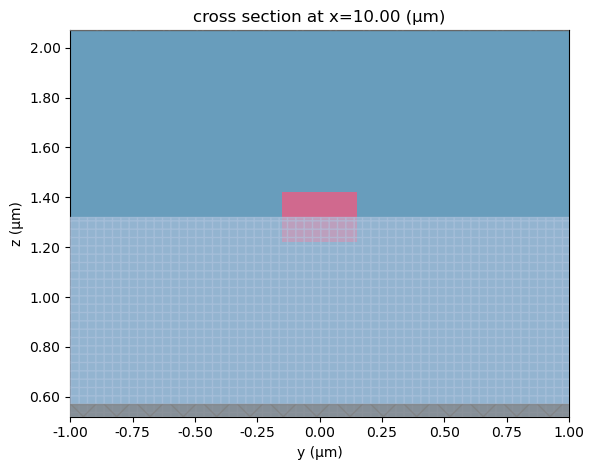

In [19]:

sp = gt.write_sparameters(
    component=c,
    **journey['settings']['full_component_args'], dilation=-0.05,
    **journey['settings']['full_modeler_args'],
    plot_mode_index=0,
    web_modes=False,
    plot_mode_port_name=c.ports[0].name,
    part=np.abs,
)
# sp = gt.write_sparameters(
#     component=c,
#     **journey['settings']['full_component_args'],
#     **journey['settings']['full_modeler_args'],
#     plot_mode_index=1,
#     web_modes=False,
#     plot_mode_port_name=c.ports[0].name,
#     part=np.abs,
# )

In [20]:
sp = gt.write_sparameters(
    component=c,
    **journey['settings']['full_component_args'], dilation=-0.05,
    **journey['settings']['full_modeler_args'],
    run_only=[('o1', 0),('o2', 0)], # run only the (port, mode_index)
)

Output()

16:33:57 EDT Started working on Batch containing 2 tasks.

16:33:59 EDT Maximum FlexCredit cost: 3.477 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

16:39:26 EDT Batch complete.

Output()

16:39:32 EDT WARNING: Simulation final field decay value of 0.00248 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 0.0404 is greater   
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Simulation saved to PosixPath('/home/floresh2/.gdsfactory/sparameters/5c0981a3a33bc50eb54560d3341b36b8a53e2631997387c5dfdff6b39cb0a27c.npz')


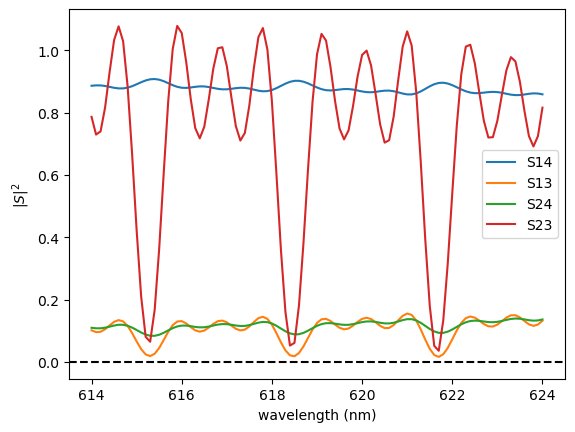

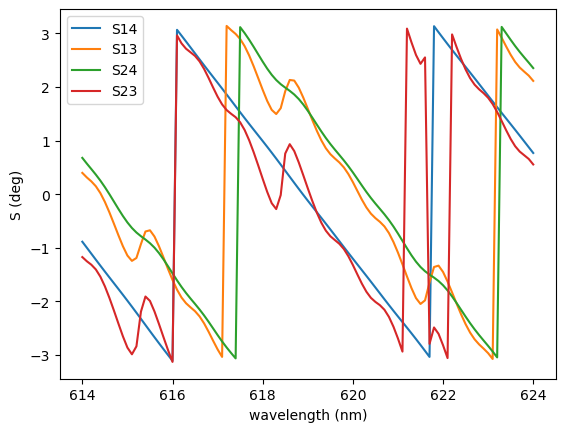

In [21]:
# Remove keys in sp that have o1 or o2 as the last two characters
sp = {k: v for k, v in sp.items() if k[-4:-2] != 'o1' and k[-4:-2] != 'o2'}

# Plot the sparameters
plt.figure()
plt.axhline(0, color='black', linestyle='--')
gp.plot.plot_sparameters(sp, logscale=False, with_simpler_labels=True)
gp.plot.plot_sparameters(sp, with_simpler_labels=True, plot_phase=True)

For port o1 - a1p1= l*a1+S

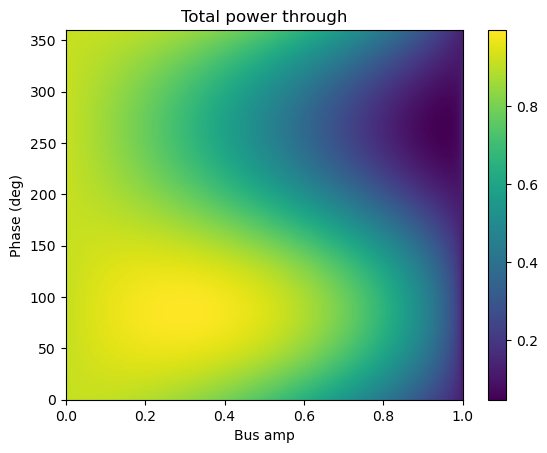

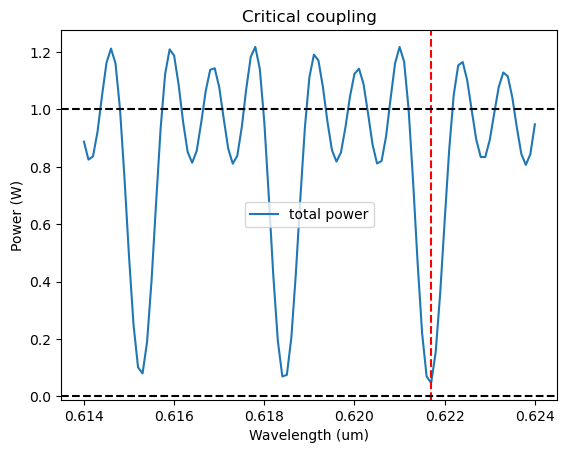

Minimum through power (0.046 W) at bus amp 0.955000, drag amp 0.296606, and phase 266.40 deg
Minimum through power (0.046 W) at wavelength 0.622 um
Maximum through power (0.995 W) at bus amp 0.295000 and phase 86.40 deg


In [24]:
res = 201
phases = np.linspace(0, 360, res)
bus_amps = np.linspace(0, 1, res)
drag_amps = np.sqrt(1-bus_amps**2)

outputs = {
    'o3': {
        'modes': [0]
    },
    'o4': {
        'modes': [0]
    }
}
# plt.figure()
min_total_powers = np.ones((res, res))
for amp_idx, (bus_amp, drag_amp) in enumerate(zip(bus_amps, drag_amps)):
    for phase_idx, input_phase in enumerate(phases):
        inputs ={
                'o1': {
                'modes': [0],
                'amps': [drag_amp],
                'phases': [input_phase*np.pi/180]
            },
                'o2': {
                'modes': [0],
                'amps': [bus_amp],
                'phases': [0]
            }
        }
        s = get_sp_output(sp, inputs, outputs)

        total_power = np.zeros(len(sp['wavelengths']))
        for s_name, s_value in s.items():
            total_power += np.abs(s_value)**2
        min_power = np.min(total_power)
        min_total_powers[phase_idx, amp_idx] = min_power

min_total_powers = np.array(min_total_powers)
plt.figure()
extent = [bus_amps[0], bus_amps[-1], phases[0], phases[-1]]
plt.imshow(min_total_powers, aspect='auto', origin='lower', extent=extent)
plt.xlabel('Bus amp')
plt.ylabel('Phase (deg)')
plt.title('Total power through')
plt.colorbar()
plt.show()

min_thru = np.unravel_index(np.argmin(min_total_powers), min_total_powers.shape)
max_thru = np.unravel_index(np.argmax(min_total_powers), min_total_powers.shape)
inputs_critical = {
    'o1': {
        'modes': [0],
        'amps': [drag_amps[min_thru[1]]],
        'phases': [phases[min_thru[0]]*np.pi/180]
    },
    'o2': {
        'modes': [0],
        'amps': [bus_amps[min_thru[1]]],
        'phases': [0]
    }
}
s_critical = get_sp_output(sp, inputs_critical, outputs)
total_power = np.zeros(len(sp['wavelengths']))
for s_name, s_value in s_critical.items():
    total_power += np.abs(s_value)**2

plt.figure()
plt.plot(sp['wavelengths'], total_power, label='total power')
plt.xlabel('Wavelength (um)')
plt.ylabel('Power (W)')
plt.title('Critical coupling')
min_power = np.min(total_power)
min_wavelength = sp['wavelengths'][np.argmin(total_power)]
plt.axvline(min_wavelength, color='r', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.axhline(1, color='k', linestyle='--')
plt.legend()
plt.show()
print(f'Minimum through power ({min_total_powers[min_thru[0], min_thru[1]]:.3f} W) at bus amp {bus_amps[min_thru[1]]:.6f}, drag amp {drag_amps[min_thru[1]]:.6f}, and phase {phases[min_thru[0]]:.2f} deg')
print(f'Minimum through power ({min_power:.3f} W) at wavelength {min_wavelength:.3f} um')
print(f'Maximum through power ({min_total_powers[max_thru[0], max_thru[1]]:.3f} W) at bus amp {bus_amps[max_thru[1]]:.6f} and phase {phases[max_thru[0]]:.2f} deg')

## Full FDTD Demonstration

Grid size (37370268) and total time steps (47067) are within daily allowance.


16:39:08 EDT Created task 'multiport_critical' with task_id                     
             'fdve-6bce97c8-a101-44af-91d1-155590bd9fe3' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=129705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=849594;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\taskId]8;;\]8;id=129705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\=]8;;\]8;id=440219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\fdve]8;;\]8;id=129705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\-6bce97c8-a10]8;;\
             ]8;id=129705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\1-44af-91d1-155590bd9fe3']8;;\.

             Task folder: ]8;id=444147;https://tidy3d.simulation.cloud/folders/folder-bccaf066-eccf-4061-aafb-95fe2ab09b26\'default']8;;\.

Output()

16:39:10 EDT Maximum FlexCredit cost: 1.257. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

16:39:11 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:39:22 EDT You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

Output()

16:41:09 EDT status = postprocess

Output()

16:41:11 EDT status = success

16:41:13 EDT View simulation result at                                          
             ]8;id=90025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=658090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\taskId]8;;\]8;id=90025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\=]8;;\]8;id=835852;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\fdve]8;;\]8;id=90025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\-6bce97c8-a10]8;;\
             ]8;id=90025;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bce97c8-a101-44af-91d1-155590bd9fe3\1-44af-91d1-155590bd9fe3']8;;\.

Output()

16:41:14 EDT loading simulation from simulation_data.hdf5

16:41:15 EDT WARNING: Simulation final field decay value of 0.0567 is greater   
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

<Axes: title={'center': 'cross section at z=1.32 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

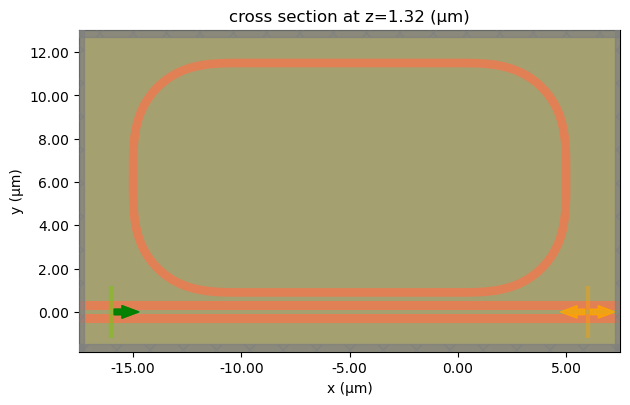

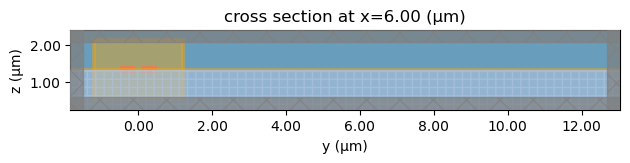

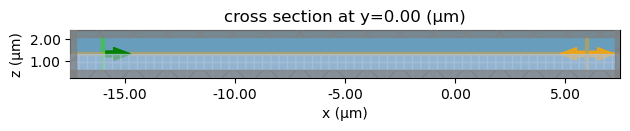

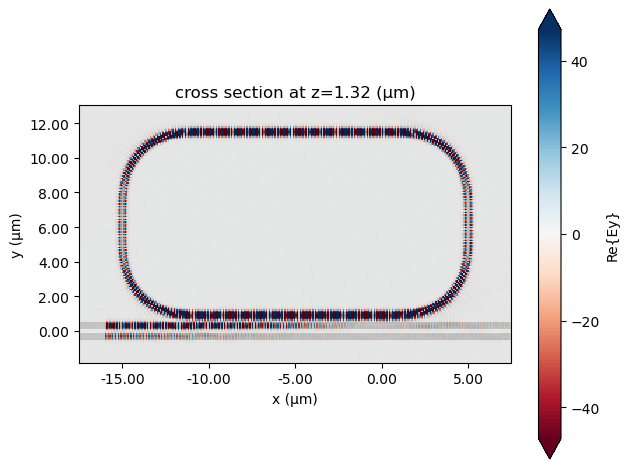

In [ ]:
outputs = {
    'o2': {
        'modes': [0, 1]
    }
}
inputs ={
    'o1': {
    'modes': [0, 1],
    'amps': [even_amps[min_thru[1]], odd_amps[min_thru[1]]],
    'phases': [0, phases[min_thru[0]]*np.pi/180]
}
}

sim = pm.tidytools.get_fdtd_sim(td_c,modeler, inputs, outputs, z_monitor='upper_nitride', z_freq=td.C_0/0.6191)
sim.plot(z=td_c.get_layer_center("upper_nitride")[2])
sim.plot(x=td_c.ports[0].dcenter[0])
sim.plot(y=td_c.ports[0].dcenter[1])
pm.tidytools.validate_sim_for_daily_allowance(sim)

job = td.web.Job(simulation=sim, task_name=f"multiport_critical", verbose=False)
data = job.run()

data.plot_field('field', 'Ey', z=td_c.get_layer_center("upper_nitride")[2])

Grid size (81850392) and total time steps (49554) are within daily allowance.


13:26:13 EDT WARNING: Simulation final field decay value of 0.00259 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

<Axes: title={'center': 'cross section at z=1.32 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

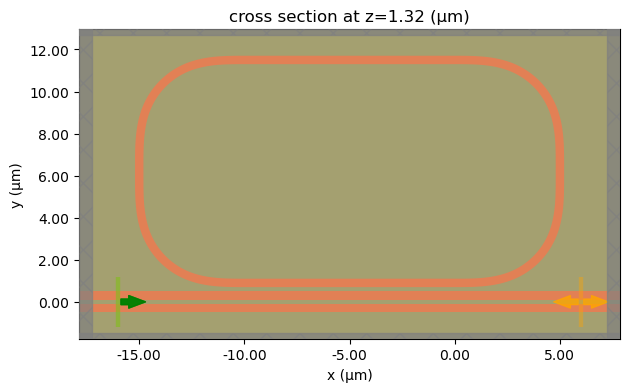

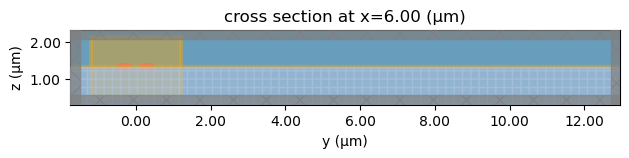

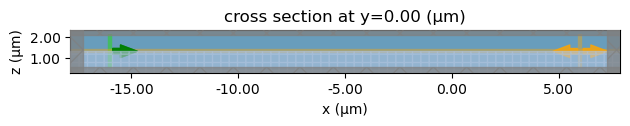

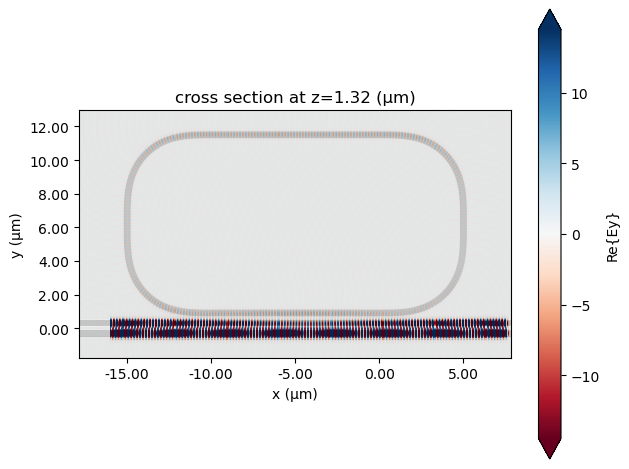

In [ ]:
outputs = {
    'o2': {
        'modes': [0, 1]
    }
}
inputs ={
    'o1': {
    'modes': [0, 1],
    'amps': [even_amps[max_thru[1]], odd_amps[max_thru[1]]],
    'phases': [0, phases[max_thru[0]]*np.pi/180]
}
}

sim = pm.tidytools.get_fdtd_sim(td_c,modeler, inputs, outputs, z_monitor='upper_nitride', z_freq=td.C_0/0.6191)
sim.plot(z=td_c.get_layer_center("upper_nitride")[2])
sim.plot(x=td_c.ports[0].dcenter[0])
sim.plot(y=td_c.ports[0].dcenter[1])
pm.tidytools.validate_sim_for_daily_allowance(sim)

job = td.web.Job(simulation=sim, task_name=f"multiport_critical", verbose=False)
data = job.run()

data.plot_field('field', 'Ey', z=td_c.get_layer_center("upper_nitride")[2])

## Save Journey

In [97]:
journey['notes'] = 'This is the first journey showing the critical coupling of the even and odd modes to a waveguide. This is a very lossy ring, so we need \
    to find out if the scheme still works with higher Q devices.'

In [98]:
# Dump the journey to a file
import dill
parent_folder = '/home/floresh2/file_system/git/pmag/dev/critical_data/'
file_path = get_date_time_file_path(parent_folder, filename="_journey1.pkl")
with open(file_path, 'wb') as f:
    dill.dump(journey, f)

# Load the journey from the file
with open(file_path, 'rb') as f:
    journey = dill.load(f)
print(journey.keys())

dict_keys(['variables', 'settings', 'notes'])
